In [ ]:
import warnings

# Suppress specific warning type
warnings.filterwarnings("ignore")

In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 48.3 MB

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig

import wandb
import evaluate

In [ ]:
from peft import (
    TaskType,
    LoraConfig,
    get_peft_model,
)

In [ ]:
emotion_data = load_dataset('rxm210132/train_val')

Generating train split:   0%|          | 0/6179 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
emotion_data['train'][0:2]

{'texts': ["Going to get myself a copy of @StephenKing's CUJO for an upcoming project that I can't talk about just yet.  #amwriting",
  "@carysmithwriter @Maria_Savva @RealRockAndRoll We're the least known band in the World, but so glad you asked #muchlove "],
 'labels': [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]]}

In [ ]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

##Load pre-trained Tokenizer

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
checkpoint = "google/gemma-1.1-2b-it"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [ ]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['texts']
)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

##Model Training

**compute_metrics function**

In [ ]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits= logits[0]
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

**Training Arguments**

In [ ]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_gemma_lora_im"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # gradient_accumulation_steps=4,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-6,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='paged_adamw_32bit',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=False,
    bf16=True,
    tf32= False
)


**Specify Model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification" )

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config

GemmaConfig {
  "_name_or_path": "google/gemma-1.1-2b-it",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 1,

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# prompt: pass two observations from tokenized dataset to datacollatior

batch = [tokenized_dataset['train'][0], tokenized_dataset['train'][1]]
batch = data_collator(batch)
batch


{'labels': tensor([[0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]]), 'input_ids': tensor([[     1,      1,      1,      2,  38173,    577,    947,   6836,    476,
           5469,    576,   1118,  28532,  15559, 235303, 235256,  38016,  15692,
            604,    671,  21429,   3542,    674,    590,    798, 235303, 235251,
           5063,   1105,   1317,   3599, 235265,    139, 235345,    563,  24168],
        [     2, 235348,   2269,    762,  34553,  12897,   1118,  30283, 235298,
          37117,    852,   1118,  11050,  20144,   2079,  29842,   1448, 235303,
            478,    573,   3476,   3836,   5974,    575,    573,   3855, 235269,
            901,    712,  11599,    692,   4351,   1700,  31519,  12870, 235248]]), 'attention_mask': tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
input_ids = batch['input_ids']
input_ids

tensor([[     1,      1,      1,      2,  38173,    577,    947,   6836,    476,
           5469,    576,   1118,  28532,  15559, 235303, 235256,  38016,  15692,
            604,    671,  21429,   3542,    674,    590,    798, 235303, 235251,
           5063,   1105,   1317,   3599, 235265,    139, 235345,    563,  24168],
        [     2, 235348,   2269,    762,  34553,  12897,   1118,  30283, 235298,
          37117,    852,   1118,  11050,  20144,   2079,  29842,   1448, 235303,
            478,    573,   3476,   3836,   5974,    575,    573,   3855, 235269,
            901,    712,  11599,    692,   4351,   1700,  31519,  12870, 235248]])

In [ ]:
pad_token_id = 2

In [ ]:
sequence_lengths = torch.eq(input_ids, pad_token_id).int().argmax(-1) - 1

In [ ]:
sequence_lengths

tensor([ 2, -1])

In [ ]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['down_proj',
 'score',
 'gate_proj',
 'q_proj',
 'up_proj',
 'v_proj',
 'o_proj',
 'k_proj']

In [ ]:
gemma_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    modules_to_save = ['score'],
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj']
)

gemma_lora_model = get_peft_model(model, gemma_peft_config )
gemma_lora_model.print_trainable_parameters()

trainable params: 156,915,712 || all params: 2,663,110,656 || trainable%: 5.892196467558275


In [ ]:
gemma_peft_config.target_modules

{'down_proj', 'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj', 'v_proj'}

In [ ]:
gemma_lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
   

##Custom Trainer

In [ ]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['labels'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['labels']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)

In [ ]:
pos_weights

tensor([ 1.7018,  6.0216,  1.6576,  4.8403,  1.6657,  8.0734,  2.3256,  7.7274,
         2.4082, 17.9540, 19.0617])

In [ ]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
gemma_lora_model.config

GemmaConfig {
  "_name_or_path": "google/gemma-1.1-2b-it",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 1,

In [ ]:
trainer = CustomTrainer(
    model=gemma_lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

##Setup WandB

In [ ]:
wandb.login()
%env WANDB_PROJECT = twitter_gemma

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=twitter_gemma


In [ ]:
trainer.train()  # start training

wandb: Currently logged in as: rakshit-mathur38 (rm12345). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,1.098700,0.931365,0.349820,0.270874,0.006472
40,0.853900,0.854121,0.399382,0.257245,0.016828
60,0.802400,0.793207,0.445971,0.295237,0.039482
80,0.736200,0.728259,0.506916,0.343608,0.075081
100,0.667300,0.675390,0.566438,0.396114,0.097087
120,0.664100,0.629364,0.591229,0.422336,0.115210
140,0.621600,0.607935,0.616297,0.451642,0.129450
160,0.566200,0.588668,0.626866,0.482050,0.118447
180,0.547200,0.577642,0.635528,0.498829,0.143042
200,0.546800,0.562234,0.646667,0.514117,0.152751


TrainOutput(global_step=970, training_loss=0.43055515559678226, metrics={'train_runtime': 759.8656, 'train_samples_per_second': 40.659, 'train_steps_per_second': 1.277, 'total_flos': 1.7584728287318016e+16, 'train_loss': 0.43055515559678226, 'epoch': 5.0})

In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.526778519153595,
 'eval_f1_micro': 0.6817036290322581,
 'eval_f1_macro': 0.5910811294576109,
 'eval_accuracy': 0.1935275080906149,
 'eval_runtime': 4.2027,
 'eval_samples_per_second': 367.617,
 'eval_steps_per_second': 11.659,
 'epoch': 5.0}

In [ ]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

**Check Confusion Matrix**

In [ ]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [ ]:
valid_output.predictions.shape

(1545, 11)

In [ ]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

In [ ]:
predictions_valid.shape

(1545, 11)

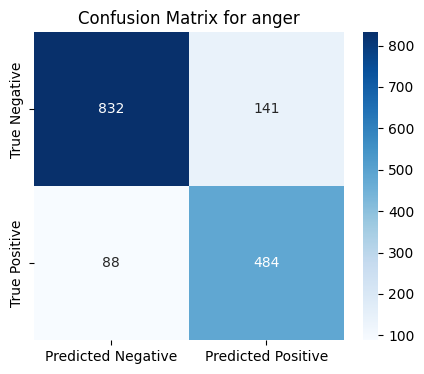

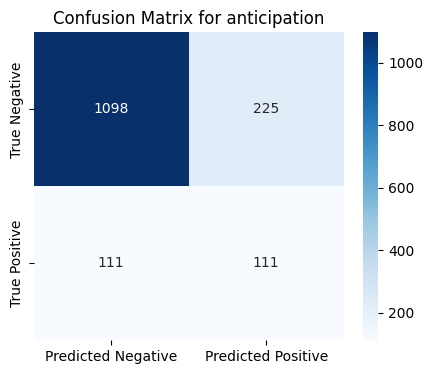

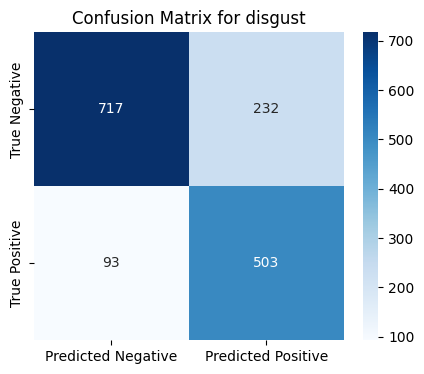

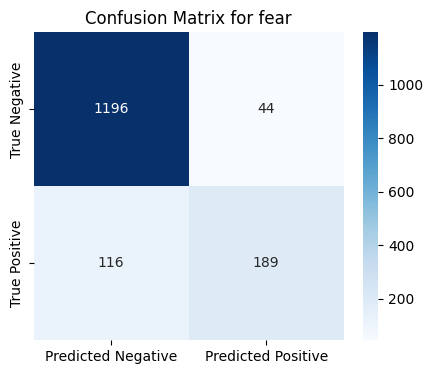

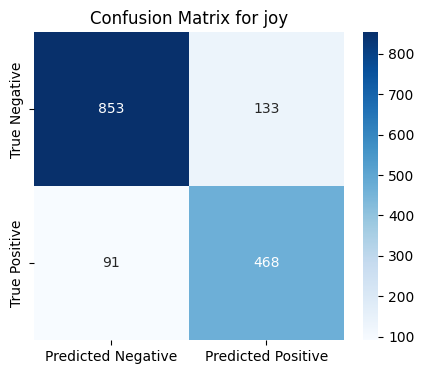

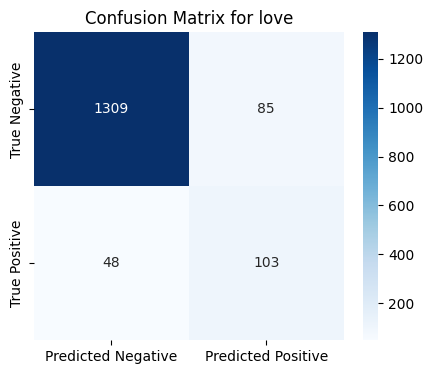

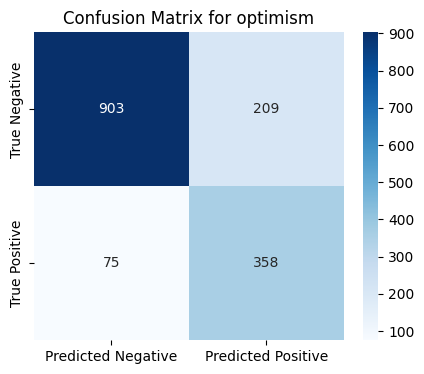

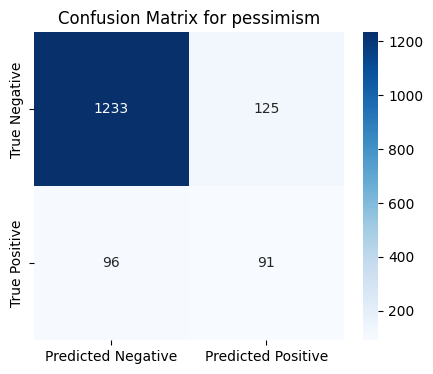

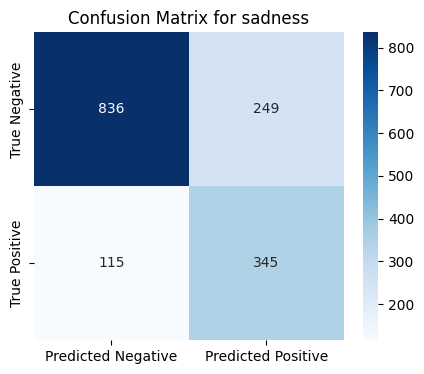

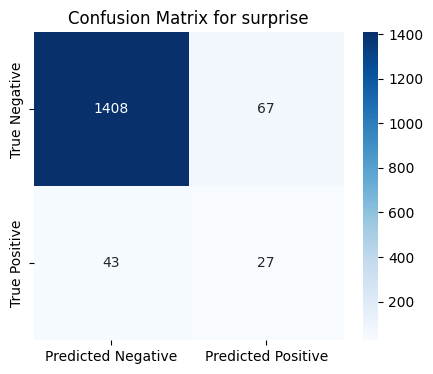

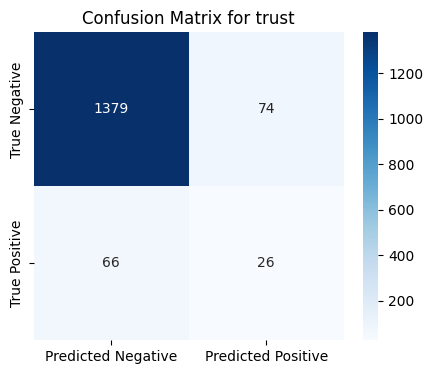

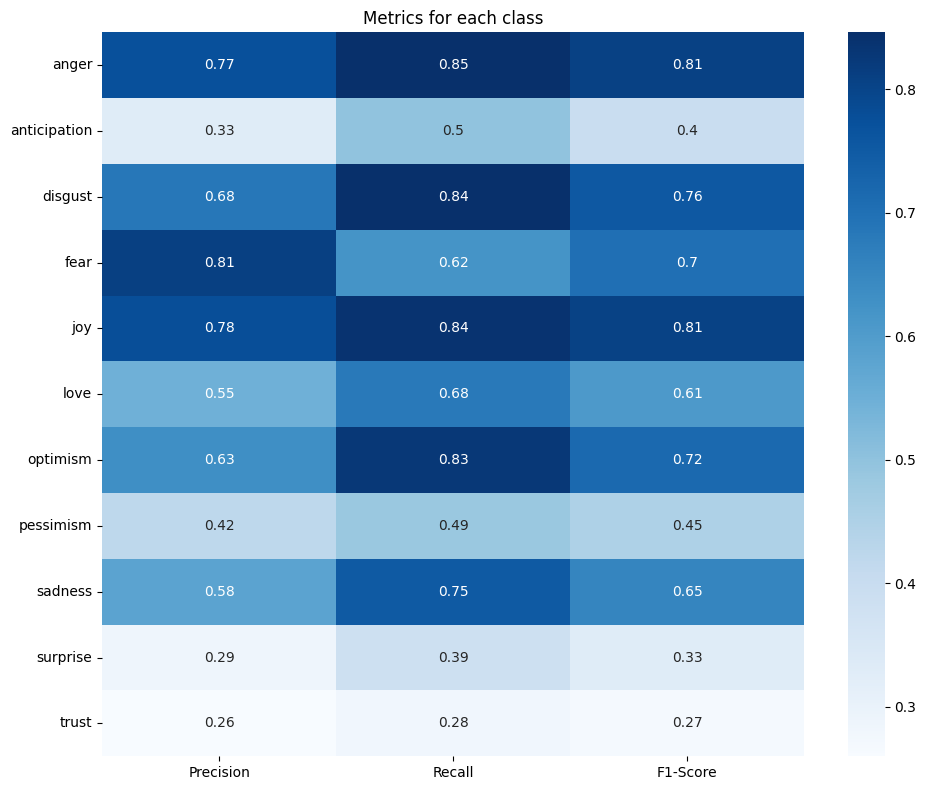

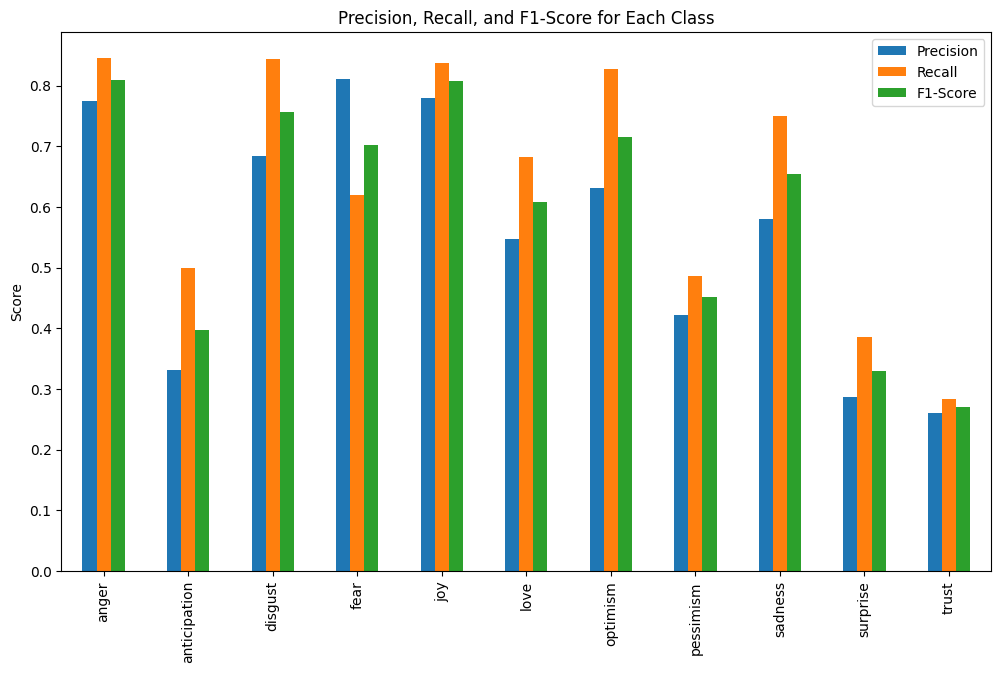

In [ ]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()


In [ ]:
gemma_lora_model.push_to_hub("rxm210132/gemma_LORA_model_emotion_detection")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/628M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rxm210132/gemma_LORA_model_emotion_detection/commit/b019925aaafcb5bcec46a142b101a576eeafd256', commit_message='Upload model', commit_description='', oid='b019925aaafcb5bcec46a142b101a576eeafd256', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
gemma_lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
   

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 560.


In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/emotions_gemma_lora_im/checkpoint-560'

##Test Set Predictions

In [57]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

peft_model_id = "rxm210132/gemma_LORA_model_emotion_detection"
config = PeftConfig.from_pretrained(peft_model_id)
config.base_model_name_or_path
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path,
                                                                num_labels=11,
                                                                problem_type="multi_label_classification")

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
# #Load the Lora model
# inference_model = PeftModel.from_pretrained(base_model, peft_model_id)

In [59]:
testset = load_dataset("rxm210132/test")

In [60]:
testset

DatasetDict({
    test: Dataset({
        features: ['texts', 'labels'],
        num_rows: 3259
    })
})

In [61]:
test_set_tokenized = testset.map(tokenize_fn, batched=True)

test_set_tokenized = test_set_tokenized.remove_columns(
    ['texts']
)

In [62]:
test_set_tokenized

DatasetDict({
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3259
    })
})

In [64]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=64,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name="emotions_gemma_lora_im"
)

In [65]:
trainer = CustomTrainer(
    model=gemma_lora_model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # Ensure no train_dataset is needed since do_train=False
)

In [66]:
test_results= trainer.evaluate()

In [67]:
test_results

{'eval_test_loss': 0.7425845265388489,
 'eval_test_f1_micro': 0.0,
 'eval_test_f1_macro': 0.0,
 'eval_test_accuracy': 0.0033752684872660325,
 'eval_test_runtime': 7.5631,
 'eval_test_samples_per_second': 430.911,
 'eval_test_steps_per_second': 6.743}

In [69]:
wandb.log({"test_accuracy": test_results["eval_test_accuracy"], "test_loss": test_results["eval_test_loss"],
"test_f1_micro": test_results["eval_test_f1_micro"], "test_f1_macro": test_results["eval_test_f1_macro"]})

**Confusion Matrix**

In [71]:
test_output = trainer.predict(test_set_tokenized['test'])

In [72]:
test_preds = (test_output.predictions > 0).astype(int)
test_labels = test_output.label_ids.astype(int)

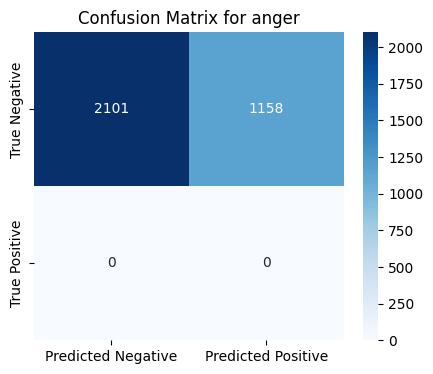

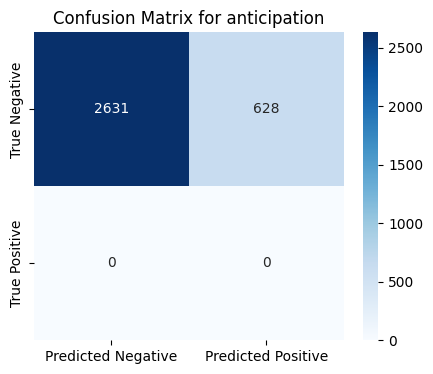

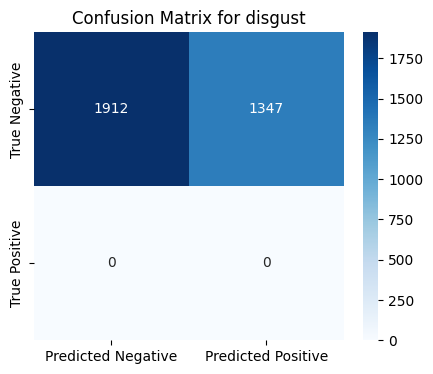

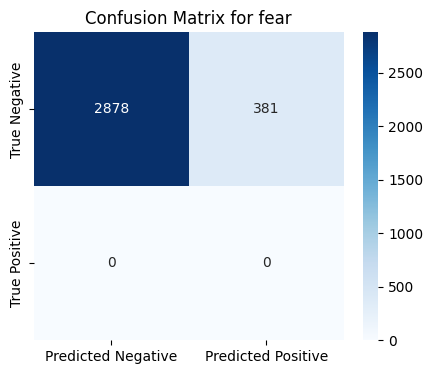

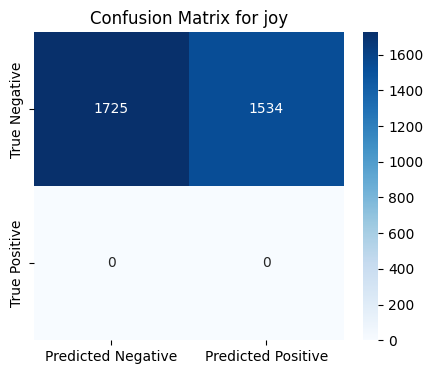

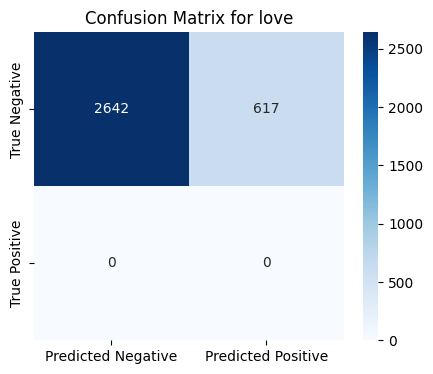

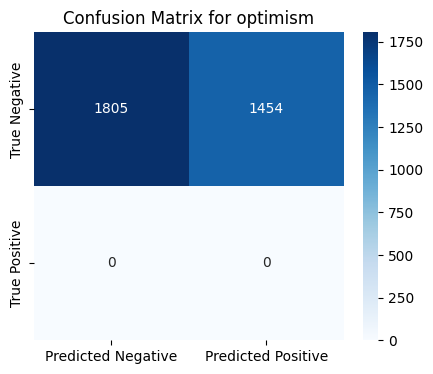

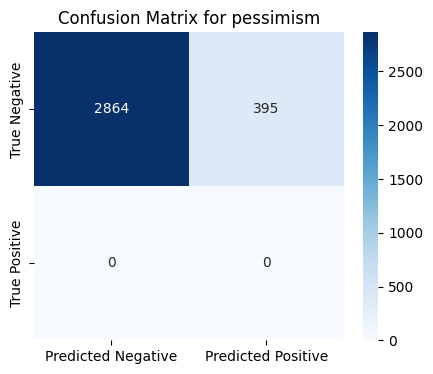

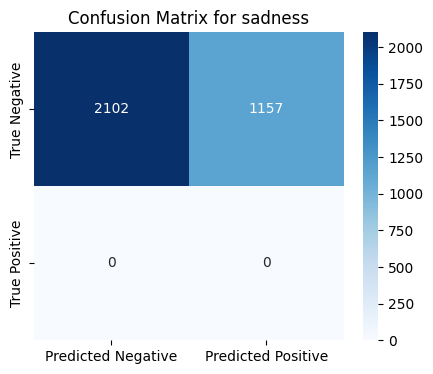

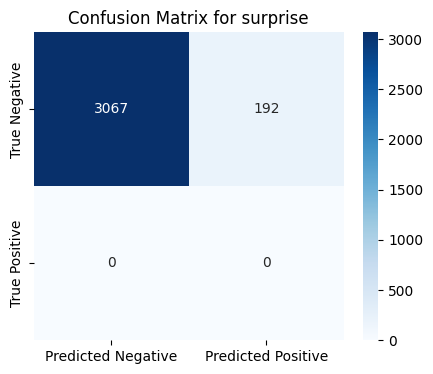

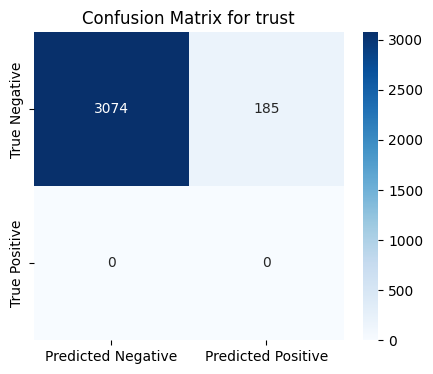

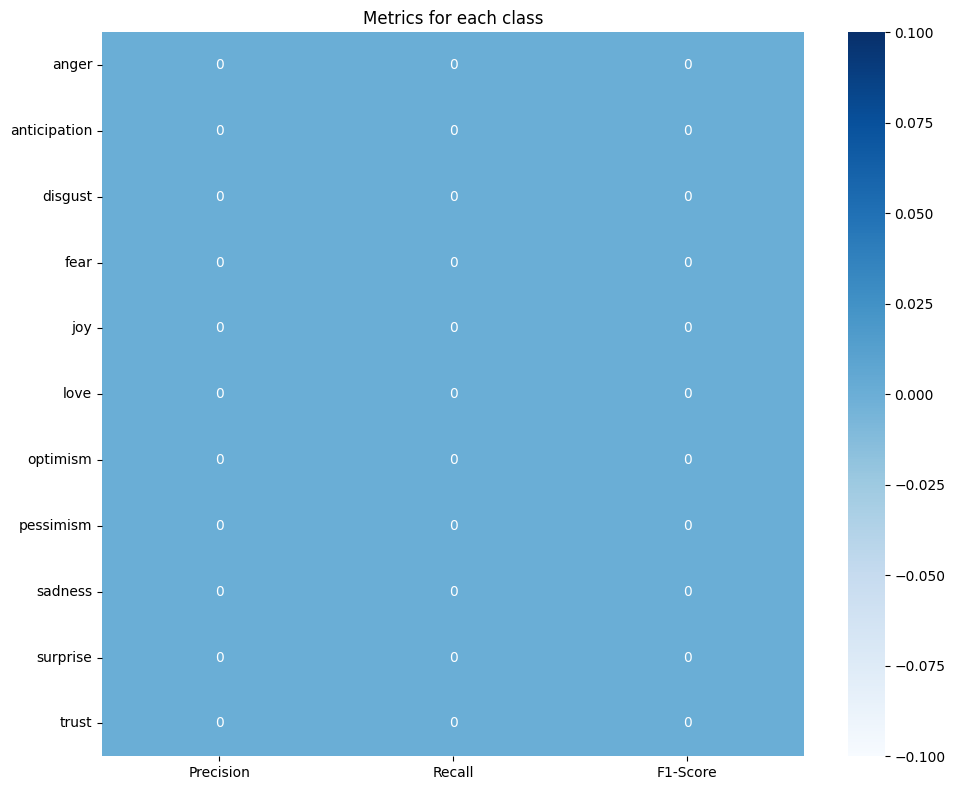

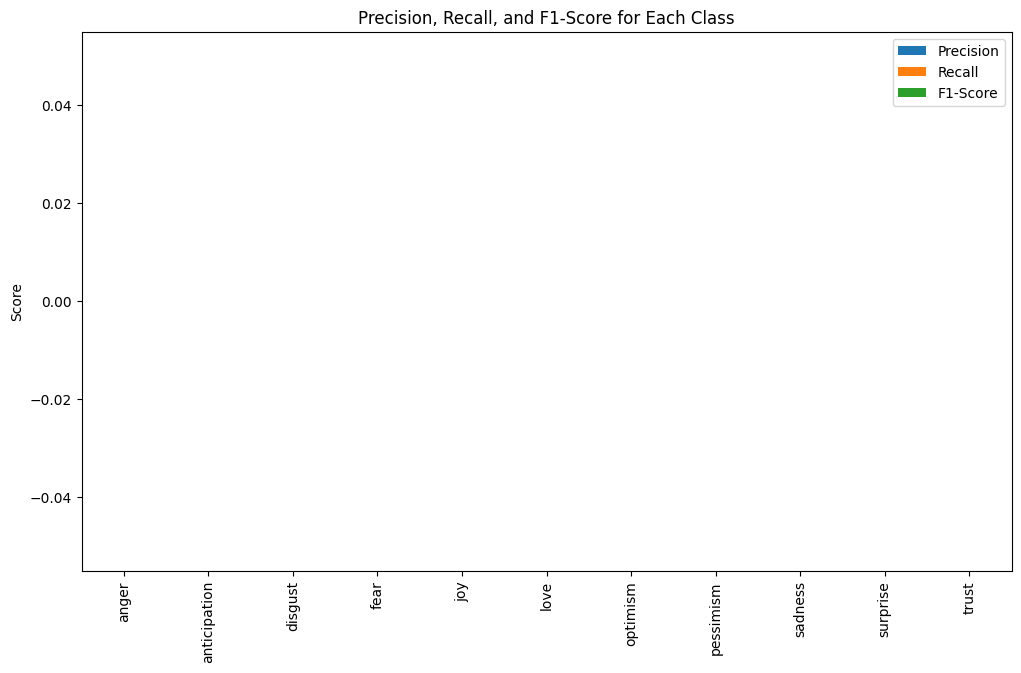

In [73]:
# Sample data
y_true = test_labels
y_pred = test_preds
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()

In [74]:
wandb.finish()

eval/accuracy,▁▁▂▃▄▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▆█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
eval/f1_macro,▁▁▂▃▄▅▆▆▆▇▇▇▇███████████████████████████
eval/f1_micro,▁▂▃▄▆▇▇▇▇███▇███████████████████████████
eval/loss,█▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁
eval/runtime,▂▃▂▂▂▁▃▂▂▂▄▁▁▅▂▂▂▂▅▁▄▂▂▆▂▂█▂▂▂▂▁▂▂▂▂█▂▂▃
eval/samples_per_second,▇▆▇▇▇█▅▇▇▇▅██▄▇▇▇▇▄█▅▇▇▃▇▇▁▇▇▇▇█▇▆▇▇▁▇▇▆
eval/steps_per_second,▇▆▇▇▇█▅▇▇▇▅██▄▇▇▇▇▄█▅▇▇▃▇▇▁▇▇▇▇█▇▆▇▇▁▇▇▆
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


##Load Results

In [75]:
%cd /content/drive/MyDrive/data/datasets/HW 5

/content/drive/MyDrive/data/datasets/HW 5


In [76]:
# Assuming the file path is correct, and you have mounted your Google Drive
df_test = pd.read_csv("test.csv")

In [77]:
df_test

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,shaft abrasions from panties merely shifted to...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3255,2018-00416,@lomadia heard of Remothered? Indie horror gam...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3256,2018-03717,All this fake outrage. Y'all need to stop 🤣,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3257,2018-03504,Would be ever so grateful if you could record ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [78]:
# Assuming 'test_preds' contains the predicted values (0 or 1) for each emotion
# Assuming 'class_names' contains the list of emotion class names

# Iterate over each emotion class name
for label in class_names:
    # Replace 'NONE' values with the predicted binary values from test_preds
    df_test[label] = test_preds[:, class_names.index(label)]

# Drop the 'Tweet' column
df_test.drop(columns=['Tweet'], inplace=True)

In [79]:
# Save the updated DataFrame to a new CSV file
#df_test.to_csv('predicted_emotions_test_gemma1.csv', index=False)

# Export to CSV
df_test.to_csv('/content/drive/MyDrive/predicted_emotions_test_gemma_lora.csv', index=False)

print("Predicted emotions saved to predicted_emotions_test_gemma.csv")

Predicted emotions saved to predicted_emotions_test_gemma.csv


In [80]:
df_test

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,0,0,0,0,0,0,1,0,0,0,0
1,2018-03739,1,0,1,0,0,0,0,0,1,0,0
2,2018-00385,1,0,1,0,0,0,0,0,1,0,0
3,2018-03001,0,0,0,0,0,0,0,1,1,0,0
4,2018-01988,0,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,1,0,1,0,0,0,0,0,1,0,0
3255,2018-00416,0,1,0,1,1,0,0,0,0,0,0
3256,2018-03717,1,0,1,0,1,0,0,0,0,0,0
3257,2018-03504,0,0,0,0,1,1,1,0,0,0,0


##Model Inference

In [81]:
from transformers import pipeline

checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Test the pipeline on a single example**

In [82]:
sample = testset['test']['texts'][0]
preds = custom_pipeline(sample)
preds

[{'label': 'LABEL_1', 'score': 0.6696652770042419}]

**Test the pipeline on a large dataset**

In [83]:
predictions = custom_pipeline(testset['test']['texts'], truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [84]:
predictions[0:10]

[{'label': 'LABEL_1', 'score': 0.6696652770042419},
 {'label': 'LABEL_0', 'score': 0.7701861262321472},
 {'label': 'LABEL_0', 'score': 0.5771499276161194},
 {'label': 'LABEL_0', 'score': 0.762026309967041},
 {'label': 'LABEL_0', 'score': 0.8654846549034119},
 {'label': 'LABEL_0', 'score': 0.9134784936904907},
 {'label': 'LABEL_0', 'score': 0.9262351393699646},
 {'label': 'LABEL_0', 'score': 0.925862193107605},
 {'label': 'LABEL_0', 'score': 0.5776851773262024},
 {'label': 'LABEL_1', 'score': 0.5350266098976135}]